In [1]:
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer, average_precision_score, precision_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

/Users/wklee/miniconda3/envs/amex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import warnings
from colorama import Fore, Back, Style
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
from lightgbm import log_evaluation

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [80]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import plot_missing_proportion_barchart, get_cols
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, CONFIRM_DROP_FEATURES
)

In [81]:
DATA_PATH = "../raw_data"
os.listdir(DATA_PATH)

['train_labels.csv',
 '.DS_Store',
 'train_pickle',
 'train_csv',
 'test_csv',
 '.ipynb_checkpoints',
 'test_parquet',
 'train_parquet',
 'sample_submission.csv',
 'test_pickle']

In [82]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [83]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
RAW_TRAIN_CSV_PATH = os.path.join(RAW_DATA_PATH, "train_csv")
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TRAIN_FEATHER_PATH = os.path.join(RAW_DATA_PATH, "train_ftr")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

### Read Data

In [85]:
id_mapping_df = pd.read_csv(f"{PROCESSED_DATA_PATH}/id_mapping_df.csv")
labels_df = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")

In [9]:
%%time
df = read_file(f"{RAW_TRAIN_PICKLE_PATH}/train_data.pkl")
# df = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data.pkl")

Shape of data: (5531451, 192)
CPU times: user 1.82 s, sys: 1.56 s, total: 3.38 s
Wall time: 3.63 s


In [10]:
df = df.drop(columns="customer_ID", errors="ignore")

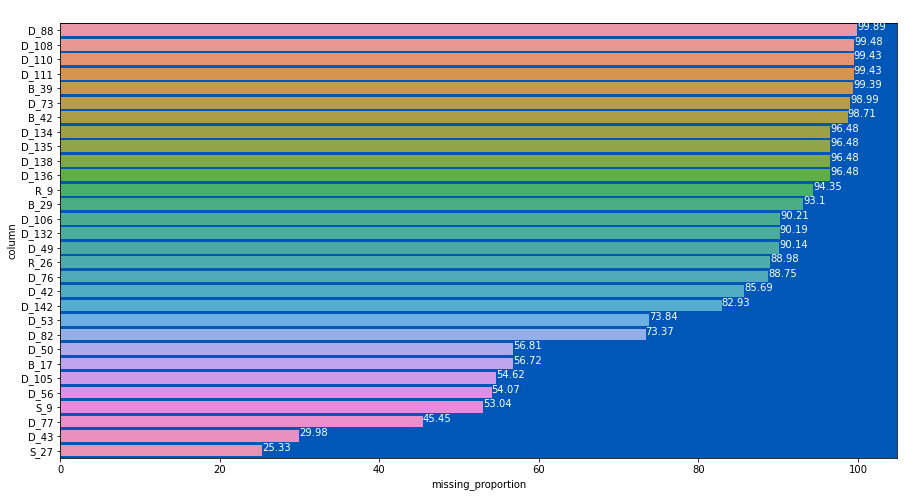

In [11]:
null_count_df = plot_missing_proportion_barchart(df)

In [12]:
if "row_number" not in df.columns:
    df.insert(1, "row_number", df.groupby("customer_ID")["S_2"].rank(method="first", ascending=False).astype(int))

In [13]:
# df.to_pickle(f"{RAW_TRAIN_PICKLE_PATH}/train_data.pkl")

### Get Lag0 Model & Feature Engineering

In [40]:
# df_lag0 = df.loc[df["row_number"] == 1].reset_index(drop=True)
# del df

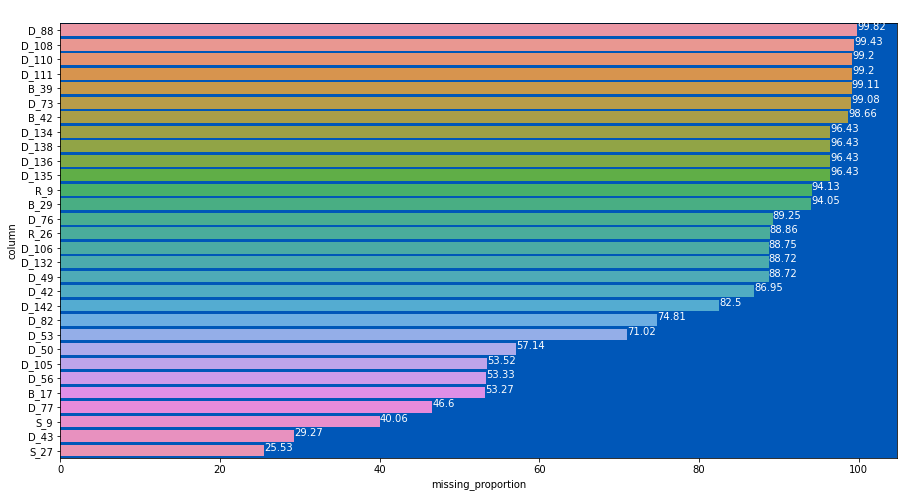

,column,missing_proportion
55,D_88,99.819792
71,D_108,99.427560
73,D_110,99.198541
74,D_111,99.198541
75,B_39,99.105495
...,...,...
43,B_26,0.006755
48,B_27,0.006755
76,D_112,0.006755
1,B_2,0.006755


In [41]:
plot_missing_proportion_barchart(df_lag0)

In [65]:
# plt.figure(figsize=(20, 10))
# sns.heatmap(df_lag0.select_dtypes("int8").corr(), cmap="coolwarm", annot=True)
# plt.show()

In [88]:
corr_df = df_lag0.loc[:, CONTINUOUS_COLUMNS].corr()

In [90]:
for column in corr_df.columns:
    pass
corr_df[column].index

Index(['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_9', 'B_10', 'B_11',
       'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_21',
       'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_36', 'B_37', 'B_39',
       'B_40', 'B_42', 'D_42', 'D_43', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49',
       'D_50', 'D_53', 'D_55', 'D_56', 'D_60', 'D_61', 'D_62', 'D_65', 'D_71',
       'D_76', 'D_73', 'D_77', 'D_88', 'D_104', 'D_105', 'D_106', 'D_107',
       'D_108', 'D_110', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121',
       'D_122', 'D_124', 'D_132', 'D_134', 'D_142', 'P_2', 'P_3', 'R_1', 'R_6',
       'R_7', 'R_12', 'R_14', 'R_18', 'R_26', 'S_3', 'S_5', 'S_7', 'S_9',
       'S_12', 'S_16', 'S_17', 'S_19', 'S_22', 'S_23', 'S_24', 'S_26', 'S_27'],
      dtype='object')

In [46]:
np.corrcoef(df_lag0["P_2"], df_lag0["target"])

array([[nan, nan],
       [nan,  1.]])

In [49]:
# for f in tqdm(features):
#     if not df_lag0[f].dtype == "category":
#         corr_coef = np.corrcoef(df_lag0[f], df_lag0["target"])
#         print(f"Feature {f} with target has Pearson corr of {corr_coef:.3f}")

### Lag0 Model Training

In [66]:
train, val = train_test_split(df_lag0, test_size=0.2, random_state=923, stratify=df_lag0["target"])

In [67]:
train.shape, val.shape

((367130, 191), (91783, 191))

In [68]:
features = train.columns[3: -1].tolist()

In [69]:
X_train = train.loc[:, features]
X_val = val.loc[:, features]

In [70]:
y_train = train["target"].values
y_val = val["target"].values

In [107]:
trial_df.loc[trial_df["value"].argmax()]

number                                              13
value                                         0.786247
datetime_start              2022-07-09 11:50:34.090481
datetime_complete           2022-07-09 12:07:38.734733
duration                        0 days 00:17:04.644252
params_colsample_bytree                       0.384856
params_learning_rate                            0.0221
params_max_bins                                    214
params_max_depth                                    17
params_min_child_samples                           164
params_n_estimators                                417
params_reg_alpha                              3.526673
params_reg_lambda                            12.054766
params_scale_pos_weight                       1.709598
params_subsample                              0.612751
params_subsample_freq                                5
state                                         COMPLETE
Name: 13, dtype: object

In [108]:
params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "reg_alpha": 3.5,
    "reg_lambda": 12,
    "learning_rate": 0.022,
    "n_estimators": 420,
    "colsample_bytree": 0.385,
    "subsample": 0.612,
    "subsample_freq": 5,
    "min_child_samples": 165,
    "scale_pos_weight": 1.7,
    "max_bins": 215,
    "max_depth": 17,
    "num_leaves": 130000
}

In [109]:
model = LGBMClassifier(**params)

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)], 
        eval_metric=[lgb_amex_metric],
        callbacks=[log_evaluation(100)]
    )

[100]	valid_0's binary_logloss: 0.259813	valid_0's amex: 0.765219


In [91]:
y_train_pred = model.predict_proba(X_train, raw_score=True)
train_score = amex_metric(y_train, y_train_pred)
y_val_pred = model.predict_proba(X_val, raw_score=True)
val_score = amex_metric(y_val, y_val_pred)

In [93]:
print(f"Train Score = {train_score:.5f}")
print(f"Val   Score = {val_score:.5f}")

Train Score = 0.92519
Val   Score = 0.78214


### Lag0 Model Tuning

In [94]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5)
    
    params = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 3.75, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 15, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.03, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 350, 450),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.25, 0.7),
        "subsample": trial.suggest_float("subsample", 0.6, 0.75),
        "subsample_freq": trial.suggest_int("subsample_freq", 4, 9),
        "min_child_samples": trial.suggest_int("min_child_samples", 150, 180),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.25, 1.75),
        "max_bins": trial.suggest_int("max_bins", 160, 250),
        "max_depth": trial.suggest_int("max_depth", 16, 18),
    }
    params["learning_rate"] = 0.05
    params["num_leaves"] = 131072 # int(2 ** (params["max_depth"] - 5))
    print(params)
    
    score_list = []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train, target)):
        X_train, X_val, y_train, y_val, model = None, None, None, None, None
        X_train = train.iloc[idx_tr][features]
        X_val = train.iloc[idx_va][features]
        y_train = target[idx_tr]
        y_val = target[idx_va]
        model = LGBMClassifier(**params)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_val, y_val)], 
                eval_metric=[lgb_amex_metric],
                verbose=-1
                # callbacks=[log_evaluation(params["n_estimators"])]
            )
        y_train_pred = model.predict_proba(X_train, raw_score=True)
        train_score = amex_metric(y_train, y_train_pred)
        X_train, y_train = None, None
        y_val_pred = model.predict_proba(X_val, raw_score=True)
        val_score = amex_metric(y_val, y_val_pred)
        print(f"Fold {fold} | Train Score = {train_score:.5f}")
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
        score_list.append(val_score)

    return np.mean(score_list)

In [95]:
study = optuna.create_study(direction="maximize")

[I 2022-07-09 02:30:37,790] A new study created in memory with name: no-name-ceab9c26-e2d4-437a-b9b3-509ea7080160


In [96]:
study.optimize(objective, n_trials=50)

{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 4.2885762929632225, 'reg_lambda': 16.73315635838172, 'learning_rate': 0.05, 'n_estimators': 352, 'colsample_bytree': 0.5362156190706394, 'subsample': 0.6498097326459632, 'subsample_freq': 8, 'min_child_samples': 175, 'scale_pos_weight': 1.9514304737613488, 'max_bins': 196, 'max_depth': 11, 'num_leaves': 131072}
Fold 1 | Train Score = 0.87907
Fold 1 | Val   Score = 0.78445
Fold 2 | Train Score = 0.87666
Fold 2 | Val   Score = 0.78679
Fold 3 | Train Score = 0.87844
Fold 3 | Val   Score = 0.79004
Fold 4 | Train Score = 0.87939
Fold 4 | Val   Score = 0.78541


[I 2022-07-09 02:36:26,925] Trial 0 finished with value: 0.7856181531316111 and parameters: {'reg_alpha': 4.2885762929632225, 'reg_lambda': 16.73315635838172, 'learning_rate': 0.014699864597955971, 'n_estimators': 352, 'colsample_bytree': 0.5362156190706394, 'subsample': 0.6498097326459632, 'subsample_freq': 8, 'min_child_samples': 175, 'scale_pos_weight': 1.9514304737613488, 'max_bins': 196, 'max_depth': 11}. Best is trial 0 with value: 0.7856181531316111.


Fold 5 | Train Score = 0.87997
Fold 5 | Val   Score = 0.78141
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 3.7734014907984434, 'reg_lambda': 11.792873030903431, 'learning_rate': 0.05, 'n_estimators': 363, 'colsample_bytree': 0.48541883391586516, 'subsample': 0.6765136794745309, 'subsample_freq': 5, 'min_child_samples': 158, 'scale_pos_weight': 1.6896822721620897, 'max_bins': 170, 'max_depth': 17, 'num_leaves': 131072}
Fold 1 | Train Score = 0.95917
Fold 1 | Val   Score = 0.78489
Fold 2 | Train Score = 0.95858
Fold 2 | Val   Score = 0.78910
Fold 3 | Train Score = 0.95972
Fold 3 | Val   Score = 0.78793
Fold 4 | Train Score = 0.95976
Fold 4 | Val   Score = 0.78656


[I 2022-07-09 02:52:28,408] Trial 1 finished with value: 0.7861059219901552 and parameters: {'reg_alpha': 3.7734014907984434, 'reg_lambda': 11.792873030903431, 'learning_rate': 0.014948616634574302, 'n_estimators': 363, 'colsample_bytree': 0.48541883391586516, 'subsample': 0.6765136794745309, 'subsample_freq': 5, 'min_child_samples': 158, 'scale_pos_weight': 1.6896822721620897, 'max_bins': 170, 'max_depth': 17}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.95926
Fold 5 | Val   Score = 0.78205
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 5.13889091923171, 'reg_lambda': 6.348595662033463, 'learning_rate': 0.05, 'n_estimators': 467, 'colsample_bytree': 0.28793786405121075, 'subsample': 0.6817843565346975, 'subsample_freq': 8, 'min_child_samples': 155, 'scale_pos_weight': 1.8102104179644505, 'max_bins': 225, 'max_depth': 13, 'num_leaves': 131072}
Fold 1 | Train Score = 0.94643
Fold 1 | Val   Score = 0.78289
Fold 2 | Train Score = 0.94649
Fold 2 | Val   Score = 0.78659
Fold 3 | Train Score = 0.94708
Fold 3 | Val   Score = 0.78967
Fold 4 | Train Score = 0.94699
Fold 4 | Val   Score = 0.78621


[I 2022-07-09 09:46:43,542] Trial 2 finished with value: 0.7854298308163248 and parameters: {'reg_alpha': 5.13889091923171, 'reg_lambda': 6.348595662033463, 'learning_rate': 0.028373468234182974, 'n_estimators': 467, 'colsample_bytree': 0.28793786405121075, 'subsample': 0.6817843565346975, 'subsample_freq': 8, 'min_child_samples': 155, 'scale_pos_weight': 1.8102104179644505, 'max_bins': 225, 'max_depth': 13}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.94829
Fold 5 | Val   Score = 0.78178
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 3.8094039762780754, 'reg_lambda': 6.223776193566484, 'learning_rate': 0.05, 'n_estimators': 456, 'colsample_bytree': 0.446481694406116, 'subsample': 0.7266090286997648, 'subsample_freq': 4, 'min_child_samples': 159, 'scale_pos_weight': 1.838391640325112, 'max_bins': 250, 'max_depth': 14, 'num_leaves': 131072}
Fold 1 | Train Score = 0.97548
Fold 1 | Val   Score = 0.78398
Fold 2 | Train Score = 0.97399
Fold 2 | Val   Score = 0.78709
Fold 3 | Train Score = 0.97410
Fold 3 | Val   Score = 0.78706
Fold 4 | Train Score = 0.97676
Fold 4 | Val   Score = 0.78492


[I 2022-07-09 10:04:33,186] Trial 3 finished with value: 0.7849673311392802 and parameters: {'reg_alpha': 3.8094039762780754, 'reg_lambda': 6.223776193566484, 'learning_rate': 0.03382879072110062, 'n_estimators': 456, 'colsample_bytree': 0.446481694406116, 'subsample': 0.7266090286997648, 'subsample_freq': 4, 'min_child_samples': 159, 'scale_pos_weight': 1.838391640325112, 'max_bins': 250, 'max_depth': 14}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.97649
Fold 5 | Val   Score = 0.78178
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 4.3789299761936915, 'reg_lambda': 17.307933743363783, 'learning_rate': 0.05, 'n_estimators': 292, 'colsample_bytree': 0.6114994747529436, 'subsample': 0.6553728791400121, 'subsample_freq': 8, 'min_child_samples': 171, 'scale_pos_weight': 2.0660738577569413, 'max_bins': 180, 'max_depth': 19, 'num_leaves': 131072}
Fold 1 | Train Score = 0.92569
Fold 1 | Val   Score = 0.78479
Fold 2 | Train Score = 0.92524
Fold 2 | Val   Score = 0.78536
Fold 3 | Train Score = 0.92630
Fold 3 | Val   Score = 0.78783
Fold 4 | Train Score = 0.92535
Fold 4 | Val   Score = 0.78445


[I 2022-07-09 10:17:50,116] Trial 4 finished with value: 0.7848361645018163 and parameters: {'reg_alpha': 4.3789299761936915, 'reg_lambda': 17.307933743363783, 'learning_rate': 0.014684076822521028, 'n_estimators': 292, 'colsample_bytree': 0.6114994747529436, 'subsample': 0.6553728791400121, 'subsample_freq': 8, 'min_child_samples': 171, 'scale_pos_weight': 2.0660738577569413, 'max_bins': 180, 'max_depth': 19}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.92721
Fold 5 | Val   Score = 0.78175
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 4.032877306792664, 'reg_lambda': 9.205191467521603, 'learning_rate': 0.05, 'n_estimators': 255, 'colsample_bytree': 0.6002277396548856, 'subsample': 0.6825266423019288, 'subsample_freq': 5, 'min_child_samples': 153, 'scale_pos_weight': 1.6518037884325814, 'max_bins': 174, 'max_depth': 14, 'num_leaves': 131072}
Fold 1 | Train Score = 0.90104
Fold 1 | Val   Score = 0.78235
Fold 2 | Train Score = 0.90054
Fold 2 | Val   Score = 0.78764
Fold 3 | Train Score = 0.90354
Fold 3 | Val   Score = 0.78997
Fold 4 | Train Score = 0.90210
Fold 4 | Val   Score = 0.78493


[I 2022-07-09 10:25:12,131] Trial 5 finished with value: 0.7854997759930898 and parameters: {'reg_alpha': 4.032877306792664, 'reg_lambda': 9.205191467521603, 'learning_rate': 0.08755906675817303, 'n_estimators': 255, 'colsample_bytree': 0.6002277396548856, 'subsample': 0.6825266423019288, 'subsample_freq': 5, 'min_child_samples': 153, 'scale_pos_weight': 1.6518037884325814, 'max_bins': 174, 'max_depth': 14}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.90109
Fold 5 | Val   Score = 0.78261
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 5.139884669125831, 'reg_lambda': 9.63824772585041, 'learning_rate': 0.05, 'n_estimators': 485, 'colsample_bytree': 0.4872129438017797, 'subsample': 0.7472065291979954, 'subsample_freq': 9, 'min_child_samples': 150, 'scale_pos_weight': 2.115174089079698, 'max_bins': 176, 'max_depth': 15, 'num_leaves': 131072}
Fold 1 | Train Score = 0.98523
Fold 1 | Val   Score = 0.78399
Fold 2 | Train Score = 0.98477
Fold 2 | Val   Score = 0.78677
Fold 3 | Train Score = 0.98517
Fold 3 | Val   Score = 0.78934
Fold 4 | Train Score = 0.98662
Fold 4 | Val   Score = 0.78521


[I 2022-07-09 10:43:39,199] Trial 6 finished with value: 0.7855469424362703 and parameters: {'reg_alpha': 5.139884669125831, 'reg_lambda': 9.63824772585041, 'learning_rate': 0.014723281480953148, 'n_estimators': 485, 'colsample_bytree': 0.4872129438017797, 'subsample': 0.7472065291979954, 'subsample_freq': 9, 'min_child_samples': 150, 'scale_pos_weight': 2.115174089079698, 'max_bins': 176, 'max_depth': 15}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.98635
Fold 5 | Val   Score = 0.78242
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 5.493244534036359, 'reg_lambda': 8.190792487578275, 'learning_rate': 0.05, 'n_estimators': 211, 'colsample_bytree': 0.5665029484885402, 'subsample': 0.7452292806695816, 'subsample_freq': 6, 'min_child_samples': 153, 'scale_pos_weight': 1.748575807787256, 'max_bins': 209, 'max_depth': 10, 'num_leaves': 131072}
Fold 1 | Train Score = 0.84319
Fold 1 | Val   Score = 0.78276
Fold 2 | Train Score = 0.84234
Fold 2 | Val   Score = 0.78850
Fold 3 | Train Score = 0.84493
Fold 3 | Val   Score = 0.78849
Fold 4 | Train Score = 0.84473
Fold 4 | Val   Score = 0.78416


[I 2022-07-09 10:46:19,392] Trial 7 finished with value: 0.784911718252744 and parameters: {'reg_alpha': 5.493244534036359, 'reg_lambda': 8.190792487578275, 'learning_rate': 0.05910548124254974, 'n_estimators': 211, 'colsample_bytree': 0.5665029484885402, 'subsample': 0.7452292806695816, 'subsample_freq': 6, 'min_child_samples': 153, 'scale_pos_weight': 1.748575807787256, 'max_bins': 209, 'max_depth': 10}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.84552
Fold 5 | Val   Score = 0.78065
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 4.711199275747101, 'reg_lambda': 14.713433734553162, 'learning_rate': 0.05, 'n_estimators': 350, 'colsample_bytree': 0.6017715554864762, 'subsample': 0.6380199013519576, 'subsample_freq': 7, 'min_child_samples': 172, 'scale_pos_weight': 1.5819014330645744, 'max_bins': 241, 'max_depth': 14, 'num_leaves': 131072}
Fold 1 | Train Score = 0.91788
Fold 1 | Val   Score = 0.78417
Fold 2 | Train Score = 0.91663
Fold 2 | Val   Score = 0.78709
Fold 3 | Train Score = 0.91701
Fold 3 | Val   Score = 0.78865
Fold 4 | Train Score = 0.92034
Fold 4 | Val   Score = 0.78583


[I 2022-07-09 10:55:49,021] Trial 8 finished with value: 0.7854553001962155 and parameters: {'reg_alpha': 4.711199275747101, 'reg_lambda': 14.713433734553162, 'learning_rate': 0.014644737584964262, 'n_estimators': 350, 'colsample_bytree': 0.6017715554864762, 'subsample': 0.6380199013519576, 'subsample_freq': 7, 'min_child_samples': 172, 'scale_pos_weight': 1.5819014330645744, 'max_bins': 241, 'max_depth': 14}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.92159
Fold 5 | Val   Score = 0.78154
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 4.622309930594406, 'reg_lambda': 13.839907150462691, 'learning_rate': 0.05, 'n_estimators': 398, 'colsample_bytree': 0.520531414117464, 'subsample': 0.6138374590024486, 'subsample_freq': 8, 'min_child_samples': 171, 'scale_pos_weight': 2.1975357721409075, 'max_bins': 182, 'max_depth': 11, 'num_leaves': 131072}
Fold 1 | Train Score = 0.88720
Fold 1 | Val   Score = 0.78413
Fold 2 | Train Score = 0.88736
Fold 2 | Val   Score = 0.78715
Fold 3 | Train Score = 0.88824
Fold 3 | Val   Score = 0.78943
Fold 4 | Train Score = 0.88981
Fold 4 | Val   Score = 0.78608


[I 2022-07-09 11:02:26,222] Trial 9 finished with value: 0.7854562960044926 and parameters: {'reg_alpha': 4.622309930594406, 'reg_lambda': 13.839907150462691, 'learning_rate': 0.07109295959068404, 'n_estimators': 398, 'colsample_bytree': 0.520531414117464, 'subsample': 0.6138374590024486, 'subsample_freq': 8, 'min_child_samples': 171, 'scale_pos_weight': 2.1975357721409075, 'max_bins': 182, 'max_depth': 11}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.88916
Fold 5 | Val   Score = 0.78050
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 3.524417680327819, 'reg_lambda': 11.640808452664224, 'learning_rate': 0.05, 'n_estimators': 397, 'colsample_bytree': 0.38291745360347085, 'subsample': 0.7056908567261472, 'subsample_freq': 4, 'min_child_samples': 162, 'scale_pos_weight': 1.5541246276033736, 'max_bins': 164, 'max_depth': 18, 'num_leaves': 131072}
Fold 1 | Train Score = 0.97151
Fold 1 | Val   Score = 0.78268
Fold 2 | Train Score = 0.97022
Fold 2 | Val   Score = 0.78727
Fold 3 | Train Score = 0.97131
Fold 3 | Val   Score = 0.78832
Fold 4 | Train Score = 0.97204
Fold 4 | Val   Score = 0.78696


[I 2022-07-09 11:20:46,391] Trial 10 finished with value: 0.7853790820144445 and parameters: {'reg_alpha': 3.524417680327819, 'reg_lambda': 11.640808452664224, 'learning_rate': 0.02586188418919296, 'n_estimators': 397, 'colsample_bytree': 0.38291745360347085, 'subsample': 0.7056908567261472, 'subsample_freq': 4, 'min_child_samples': 162, 'scale_pos_weight': 1.5541246276033736, 'max_bins': 164, 'max_depth': 18}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.97195
Fold 5 | Val   Score = 0.78166
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 4.052305597480387, 'reg_lambda': 19.957957371554787, 'learning_rate': 0.05, 'n_estimators': 337, 'colsample_bytree': 0.6904802178716628, 'subsample': 0.6531543986683509, 'subsample_freq': 6, 'min_child_samples': 179, 'scale_pos_weight': 1.9022091589427537, 'max_bins': 197, 'max_depth': 17, 'num_leaves': 131072}
Fold 1 | Train Score = 0.93550
Fold 1 | Val   Score = 0.78393
Fold 2 | Train Score = 0.93263
Fold 2 | Val   Score = 0.78678
Fold 3 | Train Score = 0.93417
Fold 3 | Val   Score = 0.78778
Fold 4 | Train Score = 0.93584
Fold 4 | Val   Score = 0.78431


[I 2022-07-09 11:34:42,633] Trial 11 finished with value: 0.784510253186782 and parameters: {'reg_alpha': 4.052305597480387, 'reg_lambda': 19.957957371554787, 'learning_rate': 0.010506870851359531, 'n_estimators': 337, 'colsample_bytree': 0.6904802178716628, 'subsample': 0.6531543986683509, 'subsample_freq': 6, 'min_child_samples': 179, 'scale_pos_weight': 1.9022091589427537, 'max_bins': 197, 'max_depth': 17}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.93460
Fold 5 | Val   Score = 0.77975
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 3.662827057696081, 'reg_lambda': 12.69268063565987, 'learning_rate': 0.05, 'n_estimators': 404, 'colsample_bytree': 0.4020311837567945, 'subsample': 0.618202014845328, 'subsample_freq': 5, 'min_child_samples': 179, 'scale_pos_weight': 1.980591118254226, 'max_bins': 199, 'max_depth': 17, 'num_leaves': 131072}
Fold 1 | Train Score = 0.95462
Fold 1 | Val   Score = 0.78525
Fold 2 | Train Score = 0.95340
Fold 2 | Val   Score = 0.78765
Fold 3 | Train Score = 0.95464
Fold 3 | Val   Score = 0.78856
Fold 4 | Train Score = 0.95593
Fold 4 | Val   Score = 0.78427


[I 2022-07-09 11:50:34,089] Trial 12 finished with value: 0.7857086195922935 and parameters: {'reg_alpha': 3.662827057696081, 'reg_lambda': 12.69268063565987, 'learning_rate': 0.020531336682865376, 'n_estimators': 404, 'colsample_bytree': 0.4020311837567945, 'subsample': 0.618202014845328, 'subsample_freq': 5, 'min_child_samples': 179, 'scale_pos_weight': 1.980591118254226, 'max_bins': 199, 'max_depth': 17}. Best is trial 1 with value: 0.7861059219901552.


Fold 5 | Train Score = 0.95461
Fold 5 | Val   Score = 0.78280
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 3.5266728012169923, 'reg_lambda': 12.054765736567584, 'learning_rate': 0.05, 'n_estimators': 417, 'colsample_bytree': 0.38485595940144524, 'subsample': 0.6127505599644891, 'subsample_freq': 5, 'min_child_samples': 164, 'scale_pos_weight': 1.7095983749456574, 'max_bins': 214, 'max_depth': 17, 'num_leaves': 131072}
Fold 1 | Train Score = 0.96294
Fold 1 | Val   Score = 0.78584
Fold 2 | Train Score = 0.96174
Fold 2 | Val   Score = 0.78756
Fold 3 | Train Score = 0.96225
Fold 3 | Val   Score = 0.78924
Fold 4 | Train Score = 0.96169
Fold 4 | Val   Score = 0.78457


[I 2022-07-09 12:07:38,735] Trial 13 finished with value: 0.7862473211628209 and parameters: {'reg_alpha': 3.5266728012169923, 'reg_lambda': 12.054765736567584, 'learning_rate': 0.02210038155107435, 'n_estimators': 417, 'colsample_bytree': 0.38485595940144524, 'subsample': 0.6127505599644891, 'subsample_freq': 5, 'min_child_samples': 164, 'scale_pos_weight': 1.7095983749456574, 'max_bins': 214, 'max_depth': 17}. Best is trial 13 with value: 0.7862473211628209.


Fold 5 | Train Score = 0.96433
Fold 5 | Val   Score = 0.78403
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 3.8425194041442947, 'reg_lambda': 10.508325229067438, 'learning_rate': 0.05, 'n_estimators': 429, 'colsample_bytree': 0.3133947877973252, 'subsample': 0.6017950589452681, 'subsample_freq': 5, 'min_child_samples': 166, 'scale_pos_weight': 1.711037660652087, 'max_bins': 216, 'max_depth': 20, 'num_leaves': 131072}
Fold 1 | Train Score = 0.96850
Fold 1 | Val   Score = 0.78151
Fold 2 | Train Score = 0.96797
Fold 2 | Val   Score = 0.78745
Fold 3 | Train Score = 0.96892
Fold 3 | Val   Score = 0.78749
Fold 4 | Train Score = 0.96874
Fold 4 | Val   Score = 0.78449


[I 2022-07-09 12:26:26,441] Trial 14 finished with value: 0.7847894632396709 and parameters: {'reg_alpha': 3.8425194041442947, 'reg_lambda': 10.508325229067438, 'learning_rate': 0.04126607072154676, 'n_estimators': 429, 'colsample_bytree': 0.3133947877973252, 'subsample': 0.6017950589452681, 'subsample_freq': 5, 'min_child_samples': 166, 'scale_pos_weight': 1.711037660652087, 'max_bins': 216, 'max_depth': 20}. Best is trial 13 with value: 0.7862473211628209.


Fold 5 | Train Score = 0.96901
Fold 5 | Val   Score = 0.78300
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 3.527897602916647, 'reg_lambda': 7.677265601433602, 'learning_rate': 0.05, 'n_estimators': 329, 'colsample_bytree': 0.3621078381570328, 'subsample': 0.7001544788009431, 'subsample_freq': 5, 'min_child_samples': 166, 'scale_pos_weight': 1.5003446562622895, 'max_bins': 225, 'max_depth': 16, 'num_leaves': 131072}
Fold 1 | Train Score = 0.94246
Fold 1 | Val   Score = 0.78677
Fold 2 | Train Score = 0.94311
Fold 2 | Val   Score = 0.78811
Fold 3 | Train Score = 0.94356
Fold 3 | Val   Score = 0.78958
Fold 4 | Train Score = 0.94301
Fold 4 | Val   Score = 0.78448


[I 2022-07-09 12:39:19,090] Trial 15 finished with value: 0.7860631418170545 and parameters: {'reg_alpha': 3.527897602916647, 'reg_lambda': 7.677265601433602, 'learning_rate': 0.02102661822285747, 'n_estimators': 329, 'colsample_bytree': 0.3621078381570328, 'subsample': 0.7001544788009431, 'subsample_freq': 5, 'min_child_samples': 166, 'scale_pos_weight': 1.5003446562622895, 'max_bins': 225, 'max_depth': 16}. Best is trial 13 with value: 0.7862473211628209.


Fold 5 | Train Score = 0.94426
Fold 5 | Val   Score = 0.78136
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 3.792289510281899, 'reg_lambda': 11.733745050593082, 'learning_rate': 0.05, 'n_estimators': 432, 'colsample_bytree': 0.41252545538982394, 'subsample': 0.6718411085646705, 'subsample_freq': 6, 'min_child_samples': 160, 'scale_pos_weight': 1.680677076868503, 'max_bins': 160, 'max_depth': 18, 'num_leaves': 131072}
Fold 1 | Train Score = 0.97846
Fold 1 | Val   Score = 0.78329
Fold 2 | Train Score = 0.97741
Fold 2 | Val   Score = 0.78545
Fold 3 | Train Score = 0.97733
Fold 3 | Val   Score = 0.78901
Fold 4 | Train Score = 0.97911
Fold 4 | Val   Score = 0.78492


[I 2022-07-09 12:59:13,953] Trial 16 finished with value: 0.7849120831639971 and parameters: {'reg_alpha': 3.792289510281899, 'reg_lambda': 11.733745050593082, 'learning_rate': 0.010257646893833537, 'n_estimators': 432, 'colsample_bytree': 0.41252545538982394, 'subsample': 0.6718411085646705, 'subsample_freq': 6, 'min_child_samples': 160, 'scale_pos_weight': 1.680677076868503, 'max_bins': 160, 'max_depth': 18}. Best is trial 13 with value: 0.7862473211628209.


Fold 5 | Train Score = 0.97888
Fold 5 | Val   Score = 0.78190
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 4.089211430631719, 'reg_lambda': 14.434352769504963, 'learning_rate': 0.05, 'n_estimators': 375, 'colsample_bytree': 0.25895886337595064, 'subsample': 0.6340821102054134, 'subsample_freq': 4, 'min_child_samples': 164, 'scale_pos_weight': 1.7772120575014723, 'max_bins': 191, 'max_depth': 16, 'num_leaves': 131072}
Fold 1 | Train Score = 0.92805
Fold 1 | Val   Score = 0.78472
Fold 2 | Train Score = 0.92838
Fold 2 | Val   Score = 0.78700
Fold 3 | Train Score = 0.92798
Fold 3 | Val   Score = 0.78826
Fold 4 | Train Score = 0.92849
Fold 4 | Val   Score = 0.78694


[I 2022-07-09 13:12:22,898] Trial 17 finished with value: 0.7858037302656318 and parameters: {'reg_alpha': 4.089211430631719, 'reg_lambda': 14.434352769504963, 'learning_rate': 0.04192612385184238, 'n_estimators': 375, 'colsample_bytree': 0.25895886337595064, 'subsample': 0.6340821102054134, 'subsample_freq': 4, 'min_child_samples': 164, 'scale_pos_weight': 1.7772120575014723, 'max_bins': 191, 'max_depth': 16}. Best is trial 13 with value: 0.7862473211628209.


Fold 5 | Train Score = 0.92897
Fold 5 | Val   Score = 0.78209
{'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'reg_alpha': 3.667832154201124, 'reg_lambda': 10.611912696212139, 'learning_rate': 0.05, 'n_estimators': 297, 'colsample_bytree': 0.3337083718720073, 'subsample': 0.6701577523254558, 'subsample_freq': 7, 'min_child_samples': 157, 'scale_pos_weight': 1.6469052253137915, 'max_bins': 212, 'max_depth': 20, 'num_leaves': 131072}
Fold 1 | Train Score = 0.93877
Fold 1 | Val   Score = 0.78390



KeyboardInterrupt



In [97]:
trial_df = study.trials_dataframe()

In [104]:
# trial_df.loc[trial_df["state"] == "COMPLETE"].to_csv(f"{EVALUATION_DATA_PATH}/trials/ori_lag0_gbdt.csv", index=False)

In [103]:
# for col in trial_df.columns[5:-1]:
#     plt.figure(figsize=(16, 8))
#     sns.scatterplot(data=trial_df.dropna(), x=col, y="value")
#     plt.title(f"{col}")
#     plt.show()

In [106]:
trial_df.loc[trial_df["value"].argmax()]

number                                              13
value                                         0.786247
datetime_start              2022-07-09 11:50:34.090481
datetime_complete           2022-07-09 12:07:38.734733
duration                        0 days 00:17:04.644252
params_colsample_bytree                       0.384856
params_learning_rate                            0.0221
params_max_bins                                    214
params_max_depth                                    17
params_min_child_samples                           164
params_n_estimators                                417
params_reg_alpha                              3.526673
params_reg_lambda                            12.054766
params_scale_pos_weight                       1.709598
params_subsample                              0.612751
params_subsample_freq                                5
state                                         COMPLETE
Name: 13, dtype: object

In [ ]:
%%time
corr_df = df.iloc[:, 3:-1].corr()

In [ ]:
null_count_df = df.iloc[:, 3:-1].isnull().sum().sort_values()

In [ ]:
potential_to_impute_columns = null_count_df[(null_count_df > 0) & (null_count_df < df.shape[0] * 0.2)].index.tolist()
potential_to_impute_null_counts = null_count_df[(null_count_df > 0) & (null_count_df < df.shape[0] * 0.2)].values.tolist()

In [ ]:
impute_col_index = 0

In [ ]:
target_impute_column = potential_to_impute_columns[impute_col_index]
target_impute_column

In [ ]:
target_impute_null_count = potential_to_impute_null_counts[impute_col_index]
target_impute_null_count

In [ ]:
high_corr_df = corr_df.loc[
    ~corr_df[target_impute_column].between(-0.4, 0.4) & ~corr_df[target_impute_column].isnull(),
    target_impute_column
]
high_corr_df = high_corr_df.abs().sort_values(ascending=False)
high_corr_df

In [ ]:
potential_features = high_corr_df.index.tolist()
potential_features.remove(target_impute_column)
print(potential_features)

In [ ]:
potential_features_null_count = df.loc[:, potential_features].isnull().sum()
potential_features = potential_features_null_count[potential_features_null_count == 0].index.tolist()
if len(potential_features) > 10:
    potential_features = potential_features[:10]
potential_features

In [ ]:
if len(potential_features) > 0:
    temp = df.loc[df[target_impute_column].isnull(), potential_features + [target_impute_column]]
    print(f"{len(potential_features)} potential feature(s), showing the target column against the first feature")
    sns.scatterplot(data=df, 
                    x=potential_features[0], 
                    y=target_impute_column)
    plt.show()
else:
    temp = df.loc[df[target_impute_column].isnull(), ["customer_ID", "row_number", target_impute_column]]
    print("No potential features, proceed with mean imputation")
    df.loc[df[target_impute_column].isnull(), target_impute_column] = df[target_impute_column].mean()
    print(f"Imputed {len(temp.index)} rows of data")

In [ ]:
# df[target_impute_column].plot.box()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
all_data = df.loc[:, ["customer_ID"] + potential_features + [target_impute_column]]

In [ ]:
train_val = all_data.loc[~all_data[target_impute_column].isnull()]
test = all_data.loc[all_data[target_impute_column].isnull()]

In [ ]:
train, val = train_test_split(train_val, test_size=0.2, random_state=1)

In [ ]:
test

In [ ]:
train.shape, val.shape, test.shape

In [ ]:
X_train = train.loc[:, potential_features]
X_val = val.loc[:, potential_features]
X_test = test.loc[:, potential_features]
y_train = train[target_impute_column]
y_val = val[target_impute_column]
y_test = test[target_impute_column]

In [ ]:
%%time
min_mse = np.inf
for k in [3, 5, 9, 13]:
    knn_model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)
    y_val_pred = knn_model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    if mse < min_mse:
        min_mse = mse
        best_knn_model = knn_model
        print(f"K: {k}, Validation MSE: {min_mse:.6f}")

In [ ]:
y_test

In [ ]:
df.loc[y_test.index, target_impute_column] = knn_model.predict(X_test)

In [ ]:
df.loc[y_test.index, target_impute_column]

In [ ]:
end

### END

### Copy from Kaggle

In [ ]:
mean_features = [f"{col}_mean" for col in MEAN_FEATURES]
mean_features[:3]

In [ ]:
min_features = [f"{col}_min" for col in MIN_FEATURES]
min_features[:3]

In [ ]:
max_features = [f"{col}_max" for col in MAX_FEATURES]
max_features[:3]

In [ ]:
last_features = [f"{col}_last" for col in LAST_FEATURES]
last_features[:3]

In [ ]:
ma_features = [col for col in train_data.columns if col.endswith("_ma")]
ma_features[:3]

In [ ]:
target = train_data["target"].values.astype(int)

In [ ]:
%%time
# Cross-validation of the classifier
ONLY_FIRST_FOLD = False
features = min_features + max_features + last_features + ma_features # mean_features + 
excluded_columns = ['B_30_mean', 'B_38_mean', 'D_114_mean', 'D_117_mean', 'D_120_mean', 'D_126_mean', 
                    'B_30_max', 'B_38_max', 'D_63_max', 'D_64_max', 'D_116_max', 'D_117_max', 'D_126_max',
                    'D_68_last', 'D_117_last']
features = [f for f in features if f not in excluded_columns]
print(f"{len(features)} features")

In [ ]:
def my_booster(random_state=1, n_estimators=1400):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, 
                          reg_alpha=10, 
                          reg_lambda=40,
                          min_child_samples=2200,
                          num_leaves=100,
                          colsample_bytree=0.18,
                          subsample=0.85,
                          max_bins=500, 
                          scale_pos_weight=2.5,
                          random_state=1)

In [ ]:
# train[["D_63_last", "D_64_last"]] = train[["D_63_last", "D_64_last"]].astype("category")

In [ ]:
# train = train_data.copy()
# del train_data

In [ ]:
n_est_list = [2200, 1500, 2000, 1000, 1600, 1800, 1800, 1200, 1400, 1000]

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
model_dict = {}
X_val_dict = {}
y_val_dict = {}
y_score_dict = {}
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    model_dict[fold] = joblib.load(f"{MODELS_PATH}/lgbm_models/model_{fold}.pkl")
    X_val_dict[fold] = train.iloc[idx_va][features]
    y_val_dict[fold] = target[idx_va]
    y_score_dict[fold] = model_dict[fold].predict_proba(X_val_dict[fold], raw_score=True)

In [ ]:
for i in range(1, 11):
    print(i)
    raw_score_ = y_score_dict[i]
    target_ = y_val_dict[i]
    main_metric, gini, top4 = amex_metric_np(raw_score_, target_)
    print(f"Main metric: {main_metric:.3f}, Gini: {gini:.3f}, Top4: {top4:.3f}")
    prob_score_ = sigmoid(raw_score_)
    print(f"ROC AUC: {roc_auc_score(target_, prob_score_):.3f}")
    print(f"Average Precision: {average_precision_score(target_, prob_score_):.3f}")

In [ ]:
full_train = pd.concat(list(X_val_dict.values()))
full_train.shape

In [ ]:
full_train_gt = np.concatenate(list(y_val_dict.values()))
len(full_train_gt)

In [ ]:
full_train_scores = np.concatenate(list(y_score_dict.values()))
len(full_train_scores)

In [ ]:
full_train.loc[:, "target"] = full_train_gt
full_train.loc[:, "score"] = full_train_scores

In [ ]:
def sigmoid(log_odds):
    return 1 / (1 + np.exp(-log_odds))

In [ ]:
full_train["prob_score"] = sigmoid(full_train["score"])

In [ ]:
roc_auc_score(full_train["target"], full_train["prob_score"])

In [ ]:
# full_train.to_csv(f"{EVALUATION_DATA_PATH}/train_single_raw_score.csv", index=False)

In [ ]:
full_train = full_train.sort_values('score', ascending=False)

In [ ]:
full_train['weight'] = full_train['target'].apply(lambda x: 20 if x==0 else 1)

In [ ]:
four_pct_cutoff = int(0.04 * full_train['weight'].sum())
full_train['weight_cumsum'] = full_train['weight'].cumsum()
full_train["is_cutoff"] = 0
full_train.loc[full_train['weight_cumsum'] <= four_pct_cutoff, "is_cutoff"] = 1

In [ ]:
top_four_pct_df = full_train.loc[full_train["is_cutoff"] == 1]

In [ ]:
full_train.shape, top_four_pct_df.shape

In [ ]:
top_four_pct_df["target"].mean()

In [ ]:
full_train.describe().iloc[:, :-5].reset_index().to_csv(f"{EVALUATION_DATA_PATH}/train_description.csv", index=False)

In [ ]:
all_neg = full_train.loc[full_train["target"] == 0]
all_pos = full_train.loc[full_train["target"] == 1]

In [ ]:
wrong_top = top_four_pct_df.loc[top_four_pct_df["target"] == 0]
correct_top = top_four_pct_df.loc[top_four_pct_df["target"] == 1]

In [ ]:
wrong_top.shape, correct_top.shape

In [ ]:
col = "B_2_min"
plt.figure(figsize=(14, 8))
sns.distplot(wrong_top[col], kde=True, hist=False, label="Wrong")
sns.distplot(correct_top[col], kde=True, hist=False, label="Right")
plt.legend()
plt.show()

In [ ]:
wrong_top["B_2_min"].min(), correct_top["B_2_min"].min()

In [ ]:
rule_list = []
for col in wrong_top.columns:
    try:
        pos_minimum = all_pos[col].min()
        temp = wrong_top.loc[wrong_top[col] < pos_minimum]
        if temp.shape[0] > 0:
            # print(col, f"Minimum bound for positive class {pos_minimum}")
            rule_list.append((col, "Minimun", pos_minimum))
        pos_maximum = all_pos[col].max()
        temp = wrong_top.loc[wrong_top[col] > pos_maximum]
        if temp.shape[0] > 0:
            # print(col, f"Maximum bound for positive class {pos_maximum}")
            rule_list.append((col, "Maximum", pos_maximum))
    except:
        continue

In [ ]:
rule_df = pd.DataFrame(rule_list, columns=["feature", "type", "value"])

In [ ]:
# rule_df.to_csv(f"{EVALUATION_DATA_PATH}/rule_df.csv", index=False)

In [ ]:
correct_top.describe()

In [ ]:
full_train

In [ ]:
X = top_four_pct_df.iloc[:, :-5].select_dtypes("float").reset_index(drop=True)
y = top_four_pct_df["target"].reset_index(drop=True)

In [ ]:
# for col in X.columns:
#     if X[col].isnull().sum() > 0:
#         X[col] = X[col].fillna(X[col].mean())
#         print(col, X[col].mean())

In [ ]:
y_val_pred

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va) in zip(range(1, 10+1), kf.split(X, y)):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = X.iloc[idx_tr]
    X_val = X.iloc[idx_va]
    y_train = y[idx_tr]
    y_val = y[idx_va]
    
    model = LogisticRegression(random_state=1020)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train)
    
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val)[:, 1]
    # print(precision_score(y_val, sigmoid(y_val_pred)))
    score = amex_metric(np.array(y_val), y_val_pred)
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = train.iloc[idx_tr][features]
    X_val = train.iloc[idx_va][features]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    
    model = my_booster(n_estimators=n_est)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_val, y_val)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(200)])
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    score = amex_metric(y_val, y_val_pred)
    n_trees = model.best_iteration_
    if n_trees is None: 
        n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    # if INFERENCE:
    #     y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    # if ONLY_FIRST_FOLD:
    #     break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

In [ ]:
for idx, model in enumerate(model_list):
    joblib.dump(model, f'../models/lgbm_models/model_{idx+1}.pkl')

### Train Val Split

In [ ]:
train, val = train_test_split(train_data, test_size=0.175, random_state=923, stratify=train_data["target"])

In [ ]:
train["target"].mean(), val["target"].mean()

In [ ]:
special_columns = ['customer_ID', 'S_2', 'target', "Date", "min_date", "max_date", "num_records", "days", "record_per_day"]

In [ ]:
all_cols = [c for c in train.columns if c not in special_columns]
cat_features = train.select_dtypes("category").columns.tolist()
num_features = [col for col in all_cols if col not in cat_features]

In [ ]:
len(all_cols), len(cat_features), len(num_features)

In [ ]:
cluster_columns = get_cols(train, "_cluster")
nunique_columns = get_cols(train, "_nunique")
non_D66_count_columns = [col for col in get_cols(train, "_count") if "D_66" not in col]

In [ ]:
selected_features = list(set(all_cols) - set(cluster_columns) - set(nunique_columns) - set(non_D66_count_columns))

In [ ]:
len(all_cols), len(selected_features)

In [ ]:
X_train = train.loc[:, selected_features]
X_val = val.loc[:, selected_features]

In [ ]:
y_train = train["target"]
y_val = val["target"]

In [ ]:
def _amex_metric(dy_true, dy_pred):
    """An eval metric that always returns the same value"""
    metric_name = 'Amex Metric'
    value = amex_metric_np(dy_pred, dy_true)
    is_higher_better = True
    return metric_name, value, is_higher_better

In [ ]:
fit_params = {"early_stopping_rounds" : 200, 
              # "eval_metric" : 'auc', 
              "eval_set" : [(X_val, y_val)],
              'eval_names': ['valid'],
              'verbose': 1,
              'categorical_feature': 'auto'}

In [ ]:
param_test = {'learning_rate' : [0.01, 0.03, 0.05, 0.07, 0.08, 0.1, 0.12],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(10, 150), 
              'min_child_samples': sp_randint(25, 300), 
              'min_child_weight': [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1],
              'min_split_gain': [0.001, 0.003, 0.01, 0.025, 0.05, 0.1],
              'subsample': sp_uniform(loc=0.4, scale=0.6), 
              # 'subsample_freq': [5, 10, 15],
              'max_depth': [-1, 3, 5, 7, 9, 11, 13, 15],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 3e-1, 1, 3, 6, 10, 20, 50],
              'reg_lambda': [0, 1e-1, 3e-1, 1, 3, 6, 10, 20, 50],
              'scale_pos_weight': [0, 1, 2, 3, 4],
              'xgboost_dart_mode': [True, False]
              }

# Number of combinations
n_iter = 50 

In [ ]:
# Intializing lgbm and lunching the search
lgbm_clf = LGBMClassifier(random_state=1020, 
                          objective="binary", 
                          boosting_type='dart', 
                          n_jobs=-1) # silent=True, 

In [ ]:
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, 
    param_distributions=param_test, 
    n_iter=n_iter,
    scoring=_amex_metric,
    cv=5,
    refit=True,
    random_state=923,
    verbose=True)

In [ ]:
grid_search.fit(X_train, y_train, **fit_params)
opt_parameters = grid_search.best_params_

In [ ]:
best_params = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.8,
    'importance_type': 'split',
    'learning_rate': 0.07,
    'max_depth': 12,
    'min_child_samples': 30,
    'min_child_weight': 0.003,
    'min_split_gain': 0.02,
    'n_estimators': 110,
    'n_jobs': -1,
    'num_leaves': 80,
    'objective': "binary",
    'random_state': 923,
    'reg_alpha': 1,
    'reg_lambda': 4,
    'silent': True,
    'subsample': 0.85,
    'subsample_for_bin': 100000,
    'subsample_freq': 5,
    'scale_pos_weight': 4
}

In [ ]:
lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
lgbm_clf.fit(X_train, y_train)

In [ ]:
y_train_pred = lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
imp_df = plot_feature_importance(lgbm_clf.feature_name_, 
                                 lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
result = pd.DataFrame()
for keyword in ["_mean", "std", "min", "max", "first", "last", "count"]:
    temp = imp_df.loc[imp_df["feature"].str.contains(keyword)].describe().rename(columns={"feature_importance": keyword})
    result = pd.concat([result, temp], axis=1)

In [ ]:
result

In [ ]:
cluster_feature_imp_df = imp_df.loc[imp_df["feature"].str.contains("count")]

In [ ]:
cluster_result = pd.DataFrame()
for keyword in ["B_", "S_", "R_", "P_", "D_"]:
    temp = cluster_feature_imp_df.loc[cluster_feature_imp_df["feature"].str.contains(keyword)].describe().rename(columns={
        "feature_importance": keyword
    })
    cluster_result = pd.concat([cluster_result, temp], axis=1)

In [ ]:
imp_df.shape[0], result.loc["count"].sum()

### Test Metric

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})

In [ ]:
# feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]
# feature_imp_thr

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

### Train once

In [ ]:
best_params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7,
 'importance_type': 'split',
 'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_samples': 50,
 'min_child_weight': 0.05,
 'min_split_gain': 0.04,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 80,
 'objective': None,
 'random_state': 1020,
 'reg_alpha': 5,
 'reg_lambda': 15,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 20000,
 'subsample_freq': 5,
 'scale_pos_weight': 1}

In [ ]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
final_lgbm_clf.fit(X_train, y_train)

In [ ]:
y_train_pred = final_lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = final_lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
# feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]
# feature_imp_thr

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

#### Final x2 LGBM

In [ ]:
selected_features = [col for col in selected_features if "first" not in col]
len(selected_features)

In [ ]:
final_lgbm_clf = LGBMClassifier(**best_params)

In [ ]:
X_train_ = X_train.loc[:, selected_features]
X_val_ = X_val.loc[:, selected_features]

In [ ]:
final_lgbm_clf.fit(X_train_, y_train)

In [ ]:
y_train_pred_ = final_lgbm_clf.predict_proba(X_train_)[:, 1]
y_val_pred_ = final_lgbm_clf.predict_proba(X_val_)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred_, y_val_pred_], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
y_res_df = pd.DataFrame(y_res).reset_index(drop=True)
y_res_pred_df = pd.DataFrame(y_res_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_res_df, y_res_pred_df)

In [ ]:
y_val.values[:40]

In [ ]:
temp_ = [1 if c > 0.95 else c for c in y_val_pred_]
# temp_[:40]

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred_).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_val_df, y_val_pred_df)

### END

### LGBM Model

In [ ]:
opt = BayesSearchCV(
    LGBMClassifier(random_state=1020),
    {
        'learning_rate': (0.04, 0.1),
        'num_leaves': (31, 127),
        'max_depth': (5, 20),
        'min_child_samples': (15, 63),
        'n_estimators': (80, 160),
        'subsample': (0.7, 0.9),
        'subsample_freq': (2, 5),
        'colsample_bytree': (0.6, 0.95),
        'reg_alpha': (0, 15),
        'reg_lambda': (0, 15),
        'min_split_gain': (0, 0.05),
        'scale_pos_weight': (0.1, 10)
    },
    n_iter=5,
    cv=5,
    scoring=make_scorer(fbeta_score, beta=2)
)

In [ ]:
start = time.time()
opt.fit(X_train, y_train, verbose=1)
end = time.time()
print(f"Done in {end - start:.2f} seconds")

In [ ]:
best_params = opt.best_estimator_.get_params()

In [ ]:
best_params

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
num_features_list, train_score_list, val_score_list = [], [], []
for imp_value in tqdm(sorted(imp_df["feature_importance"].unique())):
    selected_features = imp_df.loc[imp_df["feature_importance"] > imp_value]["feature"].tolist()
    print(f"# of features: {len(selected_features)}")
    
    X_train_new = train.loc[:, selected_features]
    X_val_new = val.loc[:, selected_features]
    
    lgbm_clf = LGBMClassifier(**params)
    lgbm_clf.fit(X_train_new, y_train)
    
    y_train_pred = lgbm_clf.predict_proba(X_train_new)[:, 1]
    y_val_pred = lgbm_clf.predict_proba(X_val_new)[:, 1]
    
    y_train_df = pd.DataFrame(y_train).reset_index(drop=True)
    y_train_pred_df = pd.DataFrame(y_train_pred).rename(columns={0: "prediction"})
    y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
    y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})
    
    train_score = amex_metric(y_train_df, y_train_pred_df)
    val_score = amex_metric(y_val_df, y_val_pred_df)
    num_features_list.append(len(selected_features))
    train_score_list.append(train_score)
    val_score_list.append(val_score)

In [ ]:
train_scores = [i[0] for i in train_score_list]
val_scores = [i[0] for i in val_score_list]

In [ ]:
eval_df = pd.DataFrame(dict(num_feature=num_features_list, 
                            train_score=train_scores, 
                            val_score=val_scores)).iloc[:-10]

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(eval_df["num_feature"], eval_df["train_score"], label="Train")
plt.plot(eval_df["num_feature"], eval_df["val_score"], label="Validation")
plt.legend()
plt.show()

### LGBM Error Analysis

In [ ]:
X_validation = X_val_.reset_index(drop=True)

In [ ]:
top4_pct_df, gini_df = get_final_metric_df(X_validation, y_val_df, y_val_pred_df)

In [ ]:
failed_top4_pct_indices = top4_pct_df.loc[(top4_pct_df["is_cutoff"] == 1) & (top4_pct_df["target"] == 0)].index

In [ ]:
# failed_top4_pct_indices

In [ ]:
failed_top4_pct_indices

In [ ]:
success_top4 = top4_pct_df.loc[~top4_pct_df.index.isin(failed_top4_pct_indices)]
failed_top4 = top4_pct_df.loc[failed_top4_pct_indices]

In [ ]:
success_top4.shape, failed_top4.shape

In [ ]:
column = "P_2_last"

In [ ]:
top4_pct_df.groupby("target")[column].mean()

In [ ]:
success_top4[column].describe()

In [ ]:
failed_top4[column].describe()

In [ ]:
# save model
# joblib.dump(final_lgbm_clf, '../models/lgbm_version1.pkl')

In [ ]:
# load model
loaded_lgbm_model = joblib.load('../models/lgbm_version1.pkl')

### SMOTE

In [ ]:
train.loc[:, num_features] = train.loc[:, num_features].fillna(0)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=923)
X_res, y_res = sm.fit_resample(train.loc[:, num_features], 
                               train["target"])

In [ ]:
X_res.shape, y_res.shape

### Inference

In [ ]:
X_test = test_data.loc[:, selected_features]

In [ ]:
y_test_pred = loaded_lgbm_model.predict_proba(X_test)[:, 1]

In [ ]:
test_data["prediction"] = y_test_pred

In [ ]:
test_data.head()

#### Submission

In [ ]:
submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

In [ ]:
submission = submission.drop(columns="prediction")

In [ ]:
result = submission.merge(test_data[["customer_ID", "prediction"]], on="customer_ID")

In [ ]:
# result.to_csv(f"{SUBMISSION_DATA_PATH}/submission4.csv", index=False)

#### Convert Data to Integer Type

In [ ]:
# for i in range(1, 11):
#     # df = read_file(f"{RAW_TRAIN_PICKLE_PATH}/train_data_{i}.pkl")
#     # df = read_file(f"{RAW_TEST_PICKLE_PATH}/test_data_{i}.pkl")
#     print(df.shape)
#     for int_col in INTEGER_COLUMNS:
#         print(f"{df[int_col].isnull().sum()} cells will be imputed")
#         df.loc[df[int_col].isnull(), int_col] = df.loc[df[int_col].isnull(), int_col].fillna(df[int_col].mean())
#         if df[int_col].isnull().sum() > 100:
#             print("Too many missing values")
#             sys.exit()
#         df[int_col] = df[int_col].round().astype(np.int8)
#     # df.to_pickle(f"{RAW_TRAIN_PICKLE_PATH}/train_data_{i}.pkl")
#     # df.to_pickle(f"{RAW_TEST_PICKLE_PATH}/test_data_{i}.pkl")
#     print(f"Test {i} done")